In [1]:
import os
os.environ["MAIN_DIR"] = ""

In [2]:
from rdkit import Chem
import pickle
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import tqdm
import json
import numpy as np
import itertools
from tabulate import tabulate

from action_utils import *

In [3]:
from action_utils import dataset

In [4]:
start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

In [5]:
from multiprocessing import Pool
import time

main_df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
N = 100000
np.random.seed(42)
steps = 5

def generate_train_data(smile):
    mol = Chem.MolFromSmiles(smile)

    df = pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
    index = []
    
    # Get sequences
    try:
        for i in range(steps):
            actions = get_applicable_actions(mol)
            if actions.shape[0] == 0:
                break

            # Apply a random action
            rand_idx = np.random.randint(0, actions.shape[0])
            product = apply_action(mol, *actions.iloc[rand_idx])

            # Add it to df
            df.loc[df.shape[0], :] = [Chem.MolToSmiles(mol)] + actions.iloc[rand_idx].tolist() + [Chem.MolToSmiles(product)]
            index.append(actions.iloc[rand_idx].name)

            # Next reactant = product
            mol = product
    except Exception as e:
        return pd.DataFrame(columns=['reactant', 'rsub', 'rcen', 'rsig', 'rsig_cs_indices', 'psub', 'pcen', 'psig', 'psig_cs_indices', 'product'])
    
    # Fix index
    df.index = index
    
    # Make combinations for multi-step possibilities of source-->target
    for i in range(df.shape[0]-1, 0, -1):
        new_df = df.iloc[:i].copy()
        new_df["product"] = df.iloc[i]["product"]
        df = pd.concat([df, new_df])
        
    return df

df_list = []
final_shape = 0
# Create dataset for 5 step pred
with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
    while final_shape < N:
        smiles = np.random.choice(start_mols, size=(1000,))

        for new_df in p.imap_unordered(generate_train_data, smiles, chunksize=10):
            df_list.append(new_df)
            final_shape += new_df.shape[0]
            
        pbar.update(final_shape - pbar.n)

main_df = pd.concat(df_list)
del df_list
print(main_df.shape)

# randomize
main_df = pd.concat([main_df[:int(main_df.shape[0]*0.8)].sample(frac=1), main_df[int(main_df.shape[0]*0.8):].sample(frac=1)])
print(main_df.shape)

107828it [03:55, 458.31it/s]                                                                         


(107828, 10)
(107828, 10)


# Neural Network!

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Epoch 1, Loss: 23151.4941
Epoch 2, Loss: 13421.6543
Epoch 3, Loss: 5006.6743
Epoch 4, Loss: 1424.6224
Epoch 5, Loss: 517.5692
Epoch 6, Loss: 364.8164
Epoch 7, Loss: 346.8831
Epoch 8, Loss: 332.0376
Epoch 9, Loss: 334.5102
Epoch 10, Loss: 327.3152

FINAL TEST LOSS: 59.57931137084961


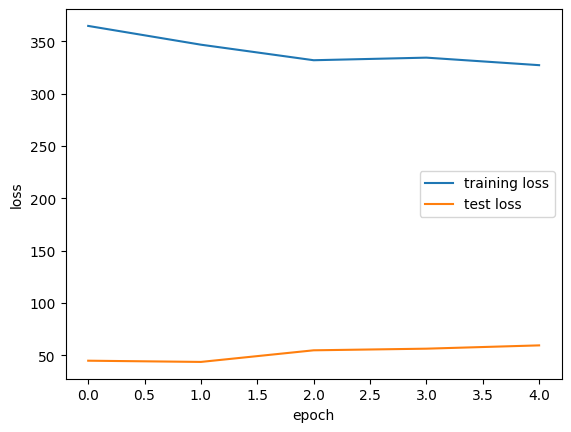

CPU times: user 7.49 s, sys: 1.26 s, total: 8.75 s
Wall time: 8.89 s


NeuralNet(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [8]:
%matplotlib inline
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=1, hidden_size=50):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.ReLU())
            
        self.last_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.last_layer(out)
        return out
    

def train(X, Y, num_hidden=1, hidden_size=50, lr=1e-2, bs=64, epochs=100):
    train_X = torch.Tensor(X[:int(X.shape[0]*0.7)]).to(device)
    train_Y = torch.Tensor(Y[:int(Y.shape[0]*0.7)]).to(device)

    test_X = torch.Tensor(X[int(X.shape[0]*0.7):]).to(device)
    test_Y = torch.Tensor(Y[int(Y.shape[0]*0.7):]).to(device)
    
    model = NeuralNet(train_X.shape[1], train_Y.shape[1], num_hidden=num_hidden, hidden_size=hidden_size).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

    loss_list = []
    test_loss = []

    # Train the model
    for epoch in range(epochs):
        for i in range(0, train_X.shape[0], batch_size):
            model.train()
            # Forward pass
            outputs = model(train_X[i:i+batch_size])
            loss = criterion(outputs, train_Y[i:i+batch_size])

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_list.append(loss.item())
        print ('Epoch {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
        
        model.eval()
        test_loss.append(criterion(model(test_X), test_Y).item()) 
    print("\nFINAL TEST LOSS:", test_loss[-1])
        
    plt.plot(loss_list[5:], label="training loss")
    plt.plot(test_loss[5:], label="test loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
        
    return model
        
from sklearn.datasets import make_regression
x, y = make_regression(n_samples=5000, n_features=20, noise=2, random_state=42)
y = y.reshape(-1, 1)

batch_size = 64

%time train(x, y, num_hidden=2, hidden_size=20, lr=1e-2, epochs=10)

# Embedding type 2 - GIN training using attribute masking on clintox

In [9]:
from torchdrug import data

In [10]:
model_name = "models/zinc2m_gin.pth"
gin_model = torch.load(model_name).to(device)

In [11]:
def molecule_from_smile(smile):
    try:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain")
    except Exception as e:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
    return mol

def get_mol_embedding(model, smiles):
    # deepchem - attribute masking
    if isinstance(smiles, str):
        mol = molecule_from_smile(smiles)
    else:
        mol = list(map(molecule_from_smile, smiles))
        mol = data.Molecule.pack(mol)
    mol = mol.to(device)
    emb = model(mol, mol.node_feature.float())["graph_feature"]
    return emb.detach().cpu().numpy()

def get_atom_embedding(model, smiles, idx):
    try:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain")
        emb = model(mol, mol.node_feature.float())["node_feature"][idx]
    except Exception as e:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
        emb = model(mol, mol.node_feature.float())["node_feature"][idx]
    return emb.detach().cpu()

def get_action_embedding(model, action_df):
    rsub, rcen, rsig, _, psub, pcen, psig, __ = [action_df[c] for c in action_df.columns]
#     print(get_mol_embedding(model, rsub).shape)
#     print(get_atom_embedding(model, rsig, rcen).shape)
#     print(get_mol_embedding(model, rsig).shape)
#     print(get_mol_embedding(model, psub).shape)
#     print(get_atom_embedding(model, psig, pcen).shape)
#     print(get_mol_embedding(model, psig).shape)
    embedding = np.concatenate([
#                         get_mol_embedding(model, rsub), 
#                         get_atom_embedding(model, rsig, rcen) / 5, 
                        get_mol_embedding(model, rsig), 
#                         get_mol_embedding(model, psub), 
#                         get_atom_embedding(model, psig, pcen) / 5, 
                        get_mol_embedding(model, psig)
                    ], axis=1)
    return embedding

In [12]:
batch_size = 64
X = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    reactants = main_df["reactant"][i:i+batch_size]
    products = main_df["product"][i:i+batch_size]
    X.append(np.concatenate([get_mol_embedding(gin_model, reactants), get_mol_embedding(gin_model, products)], axis=1))
X = np.concatenate(X, axis=0)
emb_len = X.shape[1]//2
X.shape

  1%|▎                                                             | 10/1685 [00:07<17:41,  1.58it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
  9%|█████▌                                                       | 152/1685 [01:35<16:36,  1.54it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Pb`
  warnings.warn("Unknown value `%s`" % x)
  9%|█████▌                                                       | 153/1685 [01:36<15:59,  1.60it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `As`
  warnings.warn("Unknown value `%s`" % x)
 14%|████████▌                                                    | 237/1685 [02:28<14:31,  1.66it/s]/home/abhor/mi

(107828, 256)

In [13]:
batch_size = 64
Y = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    Y.append(get_action_embedding(gin_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]]))
Y = np.concatenate(Y)
Y.shape

100%|████████████████████████████████████████████████████████████| 1685/1685 [09:23<00:00,  2.99it/s]


(107828, 256)

### MSE training

In [14]:
model = train(X, Y, hidden_size=500, num_hidden=3, lr=1e-3, epochs=100)

Epoch 1, Loss: 0.0915
Epoch 2, Loss: 0.0784
Epoch 3, Loss: 0.0661
Epoch 4, Loss: 0.0541
Epoch 5, Loss: 0.0468
Epoch 6, Loss: 0.0405
Epoch 7, Loss: 0.0353
Epoch 8, Loss: 0.0340
Epoch 9, Loss: 0.0324
Epoch 10, Loss: 0.0299
Epoch 11, Loss: 0.0277
Epoch 12, Loss: 0.0263
Epoch 13, Loss: 0.0269
Epoch 14, Loss: 0.0274
Epoch 15, Loss: 0.0250
Epoch 16, Loss: 0.0245
Epoch 17, Loss: 0.0246
Epoch 18, Loss: 0.0225
Epoch 19, Loss: 0.0232
Epoch 20, Loss: 0.0217
Epoch 21, Loss: 0.0206
Epoch 22, Loss: 0.0208
Epoch 23, Loss: 0.0238
Epoch 24, Loss: 0.0207
Epoch 25, Loss: 0.0182
Epoch 26, Loss: 0.0180
Epoch 27, Loss: 0.0195
Epoch 28, Loss: 0.0184
Epoch 29, Loss: 0.0199
Epoch 30, Loss: 0.0212
Epoch 31, Loss: 0.0223
Epoch 32, Loss: 0.0182
Epoch 33, Loss: 0.0210
Epoch 34, Loss: 0.0177
Epoch 35, Loss: 0.0167
Epoch 36, Loss: 0.0167
Epoch 37, Loss: 0.0165
Epoch 38, Loss: 0.0164
Epoch 39, Loss: 0.0179
Epoch 40, Loss: 0.0188
Epoch 41, Loss: 0.0214
Epoch 42, Loss: 0.0181
Epoch 43, Loss: 0.0167
Epoch 44, Loss: 0.01

In [15]:
torch.save(model, "datasets/my_uspto/supervised_zinc_gin/mse_model.pth")

In [16]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

def get_action_dataset_embeddings(model):
    action_embeddings = []
    for i in tqdm.tqdm(range(0, action_dataset.shape[0], batch_size)):
        action_embeddings.append(get_action_embedding(model, action_dataset.iloc[i:i+batch_size]))
    action_embeddings = np.concatenate(action_embeddings)
    return action_embeddings

action_embeddings = get_action_dataset_embeddings(gin_model)
print(action_embeddings.shape)

(89384, 8)


  7%|████▏                                                         | 94/1397 [00:30<05:47,  3.75it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
 63%|██████████████████████████████████████▍                      | 881/1397 [05:08<02:53,  2.98it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Cr`
  warnings.warn("Unknown value `%s`" % x)
 75%|█████████████████████████████████████████████▏              | 1051/1397 [06:14<02:05,  2.75it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Cd`
  warnings.warn("Unknown value `%s`" % x)
 82%|█████████████████████████████████████████████████           | 1141/1397 [06:52<02:07,  2.01it/s]/home/abhor/min

(89384, 256)


### Back to modeling

In [17]:
# I'm storing as lists, so doing numpy operations for the elements
correct_indices = []
action_embedding_indices = []

def get_emb_indices_and_correct_idx(row):
    if isinstance(row, tuple): # For pandas iterrows
        row = row[1]
    
    # Applicable indices
    applicable_actions_df = get_applicable_actions(Chem.MolFromSmiles(row["reactant"]))
    if applicable_actions_df.shape[0] == 0:
        # If there are no applicable actions detected (rdkit problems)
        indices_used_for_data = np.where((action_dataset.index == row.name))[0]
        correct_idx = 0
    else:
        indices_used_for_data = np.where(action_dataset.index.isin(applicable_actions_df.index))[0]
        
        # Correct index
        applicable_actions_df = applicable_actions_df.loc[action_dataset.iloc[indices_used_for_data].index]
        correct_idx = (applicable_actions_df.index == row.name).argmax()

    
    return indices_used_for_data, correct_idx

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
with Pool(20) as p:
    for indices_used_for_data, correct_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
        action_embedding_indices.append(indices_used_for_data)
        correct_indices.append(correct_idx)

        assert correct_indices[-1] < len(action_embedding_indices[-1]), f"WHAT!? {correct_indices[-1]} vs {len(indices_used_for_data)}"


100%|███████████████████████████████████████████████████████| 107828/107828 [09:01<00:00, 199.00it/s]


In [18]:
def get_ranking(pred, emb_for_comparison, correct_index, distance="euclidean", k=None):
    '''
    Get the rank of the prediction from the applicable actions.
    Returns (rank, [list_of_indices before <rank>])
    '''
    if distance == "euclidean":
        dist = ((emb_for_comparison-pred)**2).sum(axis=1)
    elif distance == "cosine":
        dist = 1 - (emb_for_comparison.dot(pred))/(np.linalg.norm(emb_for_comparison, axis=1)*np.linalg.norm(pred))

    maxy = max(dist)

    list_of_indices = []
    for attempt in range(dist.shape[0]):
        miny = dist.argmin()
#         print(miny, correct_index, dist[correct_index], min(dist), maxy)
        if dist[miny] == dist[correct_index]:
#             print(i, attempt)
            break
        else:
            list_of_indices.append(miny)
            if k is not None and len(list_of_indices) == k:
                return list_of_indices
            dist[miny] = 100000
    
    # When the rank(correct_index) < k, then returns <rank, list>. So this extra condition - add some indices after rank(correct_index) to the list
    if k is not None:
        dist[miny] = 100000
        for attempt in range(min(k, emb_for_comparison.shape[0]-1) - len(list_of_indices)):
            miny = dist.argmin()
            list_of_indices.append(miny)
            dist[miny] = 100000
        return list_of_indices
    return attempt, list_of_indices

def get_top_k_indices(pred, emb_for_comparison, correct_index, distance="euclidean", k=1):
    return get_ranking(pred, emb_for_comparison, correct_index, distance, k)
    
pred = model(torch.Tensor(X[int(main_df.shape[0]*0.8):]).to(device)).detach().cpu().numpy()
l = []
total = []
for i in tqdm.tqdm(range(pred.shape[0])):
    pred_for_i = pred[i]
    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[int(main_df.shape[0]*0.8)+i]], correct_indices[int(main_df.shape[0]*0.8)+i]

    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance="euclidean")
    l.append(rank)
    total.append(act_emb_for_i.shape[0])
print(f"{np.mean(l)}({np.mean(total)}) +- {np.std(l)}  ")


100%|████████████████████████████████████████████████████████| 21566/21566 [00:16<00:00, 1276.80it/s]

103.63377538718353(335.46786608550497) +- 265.8036028688515  


In [19]:
# https://github.com/mangye16/ReID-Survey
def euclidean_dist(x, y):
    """
    Args:
      x: pytorch Variable, with shape [m, d]
      y: pytorch Variable, with shape [n, d]
    Returns:
      dist: pytorch Variable, with shape [m, n]
    """
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(1, -2, x, y.t())
    dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
    return dist

def cosine_dist(x, y):
    xy = x.matmul(y.t())

    m, n = x.size(0), y.size(0)
    xx = torch.linalg.norm(x, axis=1).expand(n, m).t()
    yy = torch.linalg.norm(y, axis=1).expand(m, n)
    
    return 1 - xy / (xx*yy)


def softmax_weights(dist, mask):
    max_v = torch.max(dist * mask, dim=1, keepdim=True)[0]
    diff = dist - max_v
    Z = torch.sum(torch.exp(diff) * mask, dim=1, keepdim=True) + 1e-6 # avoid division by zero
    W = torch.exp(diff) * mask / Z
    return W

class WeightedRegularizedTriplet(object):
    def __init__(self, dist="euclidean"):
        self.ranking_loss = nn.SoftMarginLoss()
        self.dist = dist

    def __call__(self, global_feat, labels):
        if self.dist=="euclidean":
            dist_mat = euclidean_dist(global_feat, global_feat)
        elif self.dist=="cosine":
            dist_mat = cosine_dist(global_feat, global_feat) ####### NEEEDS TO BE CHANGED!!!!!!!!!!!

        N = dist_mat.size(0)
        # shape [N, N]
        is_pos = labels.expand(N, N).eq(labels.expand(N, N).t()).float()
        is_neg = labels.expand(N, N).ne(labels.expand(N, N).t()).float()

        # `dist_ap` means distance(anchor, positive)
        # both `dist_ap` and `relative_p_inds` with shape [N, 1]
        dist_ap = dist_mat * is_pos
        dist_an = dist_mat * is_neg

        weights_ap = softmax_weights(dist_ap, is_pos)
        weights_an = softmax_weights(-dist_an, is_neg)
        furthest_positive = torch.sum(dist_ap * weights_ap, dim=1)
        closest_negative = torch.sum(dist_an * weights_an, dim=1)

        y = furthest_positive.new().resize_as_(furthest_positive).fill_(1)
        loss = self.ranking_loss(closest_negative - furthest_positive, y)

        return loss

In [20]:
train_idx = np.arange(0, int(X.shape[0]*0.8))
test_idx = np.arange(int(X.shape[0]*0.8), X.shape[0])

In [21]:
%%time
%matplotlib inline
train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["reactant"]))).to(device)
train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["product"]))).to(device)

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["product"]))).to(device)

CPU times: user 14min 16s, sys: 22.3 s, total: 14min 38s
Wall time: 14min 22s


In [22]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.GIN = torch.load("models/zinc2m_gin.pth")
        self.DENSE = torch.load("datasets/my_uspto/supervised_zinc_gin/mse_model.pth")
    
    def forward(self, x1, x2):
        out1 = self.GIN(x1, x1.node_feature.float())["graph_feature"]
        out2 = self.GIN(x2, x2.node_feature.float())["graph_feature"]
        
        out = torch.concatenate([out1, out2], axis=1)
        out = self.DENSE(out)
        return out

lr = 1e-3
epochs = 50
batch_size = 128

for distance_metric, negative_method, topk, emb_model_update in itertools.product(["euclidean"], ["all"], [10, 5], [1, 2, 5]):
    print("@"*190)
    print("@"*190)
    print("@"*190)
    
    model = PolicyNetwork().to(device)
    embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
    criterion = WeightedRegularizedTriplet()
    
    action_embeddings = get_action_dataset_embeddings(embedding_model)
    action_embeddings_norm = np.linalg.norm(action_embeddings, axis=1)
    
    metric_dict = {"rank(cosine)": [], "rank(euclidean)": [], "rmse": [], "cos_dist": []}
    # Train the model
    for epoch in range(1, epochs+1):
        model.train()
        for i in range(0, train_reactants.batch_size - batch_size, batch_size):
            # Forward pass
            outputs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size])

            # Calc negatives
            negatives = []
            
            for _i in range(outputs.shape[0]):
                act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[train_idx[i+_i]]], correct_indices[train_idx[i+_i]]
                curr_out = outputs[_i].detach().cpu().numpy()

                if negative_method == "applicable":
                    top = get_top_k_indices(curr_out, act_emb_for_i, correct_index, distance=distance_metric, k=50)
                    negatives.append(act_emb_for_i[top])
                
                elif negative_method == "all":
                    if distance_metric == "euclidean":
                        dist = np.linalg.norm(action_embeddings - curr_out, axis=1)
                    elif distance_metric == "cosine":
                        dist = (1 - action_embeddings.dot(curr_out)) / (action_embeddings_norm *np.linalg.norm(curr_out))
                    sorted_idx = np.argsort(dist)[:topk] # get topk
                    sorted_idx = sorted_idx[sorted_idx != correct_index] # Remove if correct index in list
                    negatives.append(action_embeddings[sorted_idx])
                        
            negatives = torch.Tensor(np.concatenate(negatives, axis=0)).to(device)
                                
            # get targets
            targets = torch.Tensor(get_action_embedding(embedding_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]])).to(device)
                                
            # Calc loss
            inputs = torch.concat([outputs, targets, negatives])
            labels = torch.concat([torch.arange(outputs.shape[0]), torch.arange(targets.shape[0]), torch.full((negatives.shape[0],), -1)]).to(device)
            loss = criterion(inputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print ('{:.6f}({})'.format(loss.item(), epoch), end='  ')
        
        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# emb_model_update = {emb_model_update} | -ve_method = {negative_method} | dist_metric = {distance_metric} | topk = {topk} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = model(test_reactants, test_products).detach().cpu().numpy() 
            true = get_action_embedding(embedding_model, main_df.iloc[test_idx][main_df.columns[1:-1]])

            metric_df = pd.DataFrame(columns=["rmse", "cos_dist", "rank(euclidean)", "rank(cosine)"])

            # Print Test metrics
            metric_dict["rmse"].append( (((pred-true)**2).sum(axis=1)**0.5).mean() )
            metric_dict["cos_dist"].append( ((pred*true).sum(axis=1) / np.linalg.norm(pred, axis=1) / np.linalg.norm(true, axis=1)).mean() )

            # Print Test metric - Rank
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                l = []
                total = []
                for i in range(pred.shape[0]):
                    pred_for_i = pred[i]
                    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_indices[test_idx[i]]

                    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
                    l.append(rank)
                    total.append(act_emb_for_i.shape[0])
                rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                metric_dict[f"rank({dist})"].append(np.mean(l))

            for col in metric_df.columns:
                metric_df[col] = [metric_dict[col][-1]]
            metric_df.index = [epoch]
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()
            
        # Update embedding model and action_embeddings
        if epoch % emb_model_update == 0:
            embedding_model.load_state_dict(model.GIN.state_dict())
            action_embeddings = get_action_dataset_embeddings(embedding_model)
            action_embeddings_norm = np.linalg.norm(action_embeddings, axis=1)
            
    fig = plt.figure(figsize=(8, 8))
    for dist in filter(lambda x: "rank" in x, metric_dict.keys()):
        plt.plot(metric_dict[dist], label=dist)
    plt.title(distance_metric)
    plt.xlabel("epoch")
    plt.ylabel("ranking")
    plt.legend()
    fig.show()
    
    # save everything
    folder = f"models/supervised/emb_model_update={emb_model_update}||-ve_method={negative_method}||dist_metric={distance_metric}||topk={topk}"
    os.makedirs(folder, exist_ok = True)
    torch.save(model, os.path.join(folder, "model.pth"))
    pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))
    fig.savefig(os.path.join(folder, "plot.png"))
    json.dump({
        "lr": lr,
        "epochs": epochs, 
        "batch_size": batch_size,
        "train_samples": train_idx.shape,
        "test_samples": test_idx.shape,
        "distance_metric": distance_metric,
        "negative_method": negative_method,
        "topk": topk,
        "emb_model_update": emb_model_update,
    }, open(os.path.join(folder, "config.txt"), 'w'))

In [ ]:
lr = 1e-3
epochs = 20
batch_size = 128


for distance_metric, negative_method, topk, emb_model_update in itertools.product(["euclidean"], ["all"], [10], [1, 2, 5]):
    print("@"*190)
    print("@"*190)
    print("@"*190)
    
    best_rank = 10000
    best_model = None
    
    model = PolicyNetwork().to(device)
    embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
    criterion = WeightedRegularizedTriplet()
    
    action_embeddings = get_action_dataset_embeddings(embedding_model)
    action_embeddings_norm = np.linalg.norm(action_embeddings, axis=1)
    
    metric_dict = {"rank(cosine)": [], "rank(euclidean)": [], "rmse": [], "cos_dist": []}
    # Train the model
    for epoch in range(1, epochs+1):
        model.train()
        for i in range(0, train_reactants.batch_size - batch_size, batch_size):
            # Forward pass
            outputs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size])

            # Calc negatives
            negatives = []
            
            for _i in range(outputs.shape[0]):
                act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[train_idx[i+_i]]], correct_indices[train_idx[i+_i]]
                curr_out = outputs[_i].detach().cpu().numpy()

                if negative_method == "applicable":
                    top = get_top_k_indices(curr_out, act_emb_for_i, correct_index, distance=distance_metric, k=50)
                    negatives.append(act_emb_for_i[top])
                
                elif negative_method == "all":
                    if distance_metric == "euclidean":
                        dist = np.linalg.norm(action_embeddings - curr_out, axis=1)
                    elif distance_metric == "cosine":
                        dist = (1 - action_embeddings.dot(curr_out)) / (action_embeddings_norm *np.linalg.norm(curr_out))
                    sorted_idx = np.argsort(dist)[:topk] # get topk
                    sorted_idx = sorted_idx[sorted_idx != correct_index] # Remove if correct index in list
                    negatives.append(action_embeddings[sorted_idx])
                        
            negatives = torch.Tensor(np.concatenate(negatives, axis=0)).to(device)
                                
            # get targets
            targets = torch.Tensor(get_action_embedding(embedding_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]])).to(device)
                                
            # Calc loss
            inputs = torch.concat([outputs, targets, negatives])
            labels = torch.concat([torch.arange(outputs.shape[0]), torch.arange(targets.shape[0]), torch.full((negatives.shape[0],), -1)]).to(device)
            loss = criterion(inputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print ('{:.6f}({})'.format(loss.item(), epoch), end='  ')
        
        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# emb_model_update = {emb_model_update} | -ve_method = {negative_method} | dist_metric = {distance_metric} | topk = {topk} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = model(test_reactants, test_products).detach().cpu().numpy() 
            true = get_action_embedding(embedding_model, main_df.iloc[test_idx][main_df.columns[1:-1]])

            metric_df = pd.DataFrame(columns=["rmse", "cos_dist", "rank(euclidean)", "rank(cosine)"])

            # Print Test metrics
            metric_dict["rmse"].append( (((pred-true)**2).sum(axis=1)**0.5).mean() )
            metric_dict["cos_dist"].append( ((pred*true).sum(axis=1) / np.linalg.norm(pred, axis=1) / np.linalg.norm(true, axis=1)).mean() )

            # Print Test metric - Rank
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                l = []
                total = []
                for i in range(pred.shape[0]):
                    pred_for_i = pred[i]
                    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_indices[test_idx[i]]

                    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
                    l.append(rank)
                    total.append(act_emb_for_i.shape[0])
                rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                metric_dict[f"rank({dist})"].append(np.mean(l))

            for col in metric_df.columns:
                metric_df[col] = [metric_dict[col][-1]]
            metric_df.index = [epoch]
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()
            
        # Update embedding model and action_embeddings
        if epoch % emb_model_update == 0:
            embedding_model.load_state_dict(model.GIN.state_dict())
            action_embeddings = get_action_dataset_embeddings(embedding_model)
            action_embeddings_norm = np.linalg.norm(action_embeddings, axis=1)
        
        # Update best model
        if metric_dict["rank(euclidean)"][-1] < best_rank:
            best_rank = metric_dict["rank(euclidean)"][-1]
            best_model = type(model)()
            best_model.load_state_dict(model.state_dict())
            best_epoch = epoch
            print(f"BEST MODEL UPDATED! BEST RANK = {best_rank}")
            
    fig = plt.figure(figsize=(8, 8))
    for dist in filter(lambda x: "rank" in x, metric_dict.keys()):
        plt.plot(metric_dict[dist], label=dist)
    plt.title(distance_metric)
    plt.xlabel("epoch")
    plt.ylabel("ranking")
    plt.legend()
    fig.show()
    
    # save everything
    folder = f"models/supervised/5step/emb_model_update={emb_model_update}||-ve_method={negative_method}||dist_metric={distance_metric}||topk={topk}"
    os.makedirs(folder, exist_ok = True)
    torch.save(model, os.path.join(folder, "model.pth"))
    pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))
    fig.savefig(os.path.join(folder, "plot.png"))
    json.dump({
        "lr": lr,
        "epochs": epochs, 
        "batch_size": batch_size,
        "train_samples": train_idx.shape,
        "test_samples": test_idx.shape,
        "distance_metric": distance_metric,
        "negative_method": negative_method,
        "topk": topk,
        "emb_model_update": emb_model_update,
        "best_epoch": best_epoch,
        "best_rank": best_rank
    }, open(os.path.join(folder, "config.txt"), 'w'))

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


100%|██████████████████████████████████████████████████████████████| 699/699 [05:14<00:00,  2.23it/s]


2.939456(1)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  1 │ 5.40174 │   0.712225 │           95.1163 │        90.5212 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:14<00:00,  2.22it/s]


BEST MODEL UPDATED! BEST RANK = 95.11629416674396
3.771772(2)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  2 │ 5.37406 │   0.723317 │            93.805 │        88.5706 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:12<00:00,  2.24it/s]


BEST MODEL UPDATED! BEST RANK = 93.80497078735046
3.790295(3)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  3 │ 5.36645 │   0.727116 │           92.8755 │        87.6982 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:11<00:00,  2.24it/s]


BEST MODEL UPDATED! BEST RANK = 92.87554483909858
3.850317(4)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  4 │ 5.32654 │     0.7308 │           93.7858 │        87.3741 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:10<00:00,  2.25it/s]


6.254366(5)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  5 │ 5.35856 │   0.729853 │           91.4537 │        86.1973 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:10<00:00,  2.25it/s]


BEST MODEL UPDATED! BEST RANK = 91.45372345358435
2.841396(6)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  6 │ 5.27396 │   0.736233 │           92.4302 │           86.3 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:08<00:00,  2.27it/s]


5.641994(7)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  7 │ 5.26165 │   0.740818 │            91.224 │        85.6658 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:00<00:00,  2.32it/s]


BEST MODEL UPDATED! BEST RANK = 91.22396364648057
5.712537(8)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  8 │ 5.29801 │   0.740434 │           92.0502 │        86.2231 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:01<00:00,  2.32it/s]


6.446737(9)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  9 │ 5.26701 │   0.744009 │           90.5809 │        84.2438 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:59<00:00,  2.33it/s]


BEST MODEL UPDATED! BEST RANK = 90.58086803301494
4.568167(10)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤════════════╤═══════════════════╤════════════════╕
│    │   rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪════════╪════════════╪═══════════════════╪════════════════╡
│ 10 │  5.254 │   0.746956 │           89.9424 │        84.5942 │
╘════╧════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:01<00:00,  2.32it/s]


BEST MODEL UPDATED! BEST RANK = 89.94240934804785
3.987677(11)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 11 │ 5.23925 │   0.746372 │           91.2803 │        84.8132 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:59<00:00,  2.33it/s]


4.273151(12)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 12 │ 5.28543 │   0.745857 │            92.276 │        85.8269 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:09<00:00,  2.26it/s]


5.087873(13)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 13 │ 5.27949 │   0.747382 │           89.3641 │        83.3814 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:18<00:00,  2.19it/s]


BEST MODEL UPDATED! BEST RANK = 89.36409162570713
